# 3D VoCC area depth investigation

We show in this notebook where 3D VoCC differs from the the 2D py-eddy-tracker.
Resrach questions in oceanography contain the volume of eddies to determine the heat and salt transport between ocean basins.
3D VoCC is able to track three components that are not able to track in 2D and are important for the volume calculation:

1. Straightforward but still important is an estimation of the depth of an eddy.
2. Typically the diameter of an eddy decreses with depth.
3. An eddy is not a perfect cone pointing to the seafloor but rather the centers of the deeper layers diverges from the centers in the upper layers.

In [1]:
from shapely.geometry import Point
import matplotlib.pyplot as plt
from cartopy.crs import PlateCarree
from cartopy.feature import LAND, COASTLINE
from py_eddy_tracker.dataset.grid import UnRegularGridDataset
from datetime import datetime
import numpy as np
from VoCC import VortexCorrelationClustering
%run ../scripts/experiment_utils.py

MIN_PARTICLES = 40
DEPTH_STRIDE = 6

font_size = 16

## Preperation

In [2]:
def get_py_eddy_tracker_labels():
    g = UnRegularGridDataset('../data/ssh_u_v_1d_20111029.nc',
                        'nav_lon', 'nav_lat', centered=True)
    g.high_filter('ssh',w_cut=700,factor=8.0)
    date = datetime(2011,10,29)
    a,c = g.eddy_identification('ssh', 'u', 'v', date = date, step=0.004, shape_error=70)


    # Load the particles dataset

    coordinates = np.load('../data/particles_29102011.npy')
    X,Y,U,V = coordinates[::3].T

    # The magnitude of the movement are two days we normalize them to one.
    U /= 2
    V /= 2
    # Set outliers to zero
    U[U > 1] = 0
    V[V > .5] = 0

    def extract_lagrangian_eddies(eddy_dataset, particles_x, particles_y, particle_threshold):
        counts, _ = np.histogram(eddy_dataset.contains(particles_x, particles_y), bins = np.arange( len(eddy_dataset)+1))
        mask_indices = np.argwhere(counts >= particle_threshold).squeeze()

        mask = np.zeros(len(eddy_dataset.obs), dtype=bool)
        mask[mask_indices] = True

        return eddy_dataset.extract_with_mask(mask)


    particle_eddy_a = extract_lagrangian_eddies(a, X, Y, MIN_PARTICLES).contains(coordinates[:,0],coordinates[:, 1])
    particle_eddy_c = extract_lagrangian_eddies(c, X, Y, MIN_PARTICLES).contains(coordinates[:,0],coordinates[:, 1])

    particle_eddy_c[particle_eddy_c >= 0] += particle_eddy_a.max() +1

    particle_eddy_labels = np.max(np.vstack((particle_eddy_a, particle_eddy_c)), axis = 0)
    return particle_eddy_labels, a, c

particle_eddy_labels, a, c = get_py_eddy_tracker_labels()

In [3]:
coordinates = np.load('../data/particles_29102011_depth.npy')
X,Y,U,V,D = coordinates.T

# The magnitude of the movement are two days we normalize them to one.
U /= 2
V /= 2
# Set outliers to zero
U[U > 1] = 0
V[V > .5] = 0

In [4]:
vocc = VortexCorrelationClustering(
    radii=np.arange(4,24,4),
    cell_size= .07, 
    sectors = 15, 
    circle_coverage_rate = .75, 
    qth_threshold = .99, 
    min_points = .01,
    depth_boundaries=-depth_layers[::DEPTH_STRIDE]
)
default_labels = vocc.fit(coordinates).labels_

<GeoAxes: >

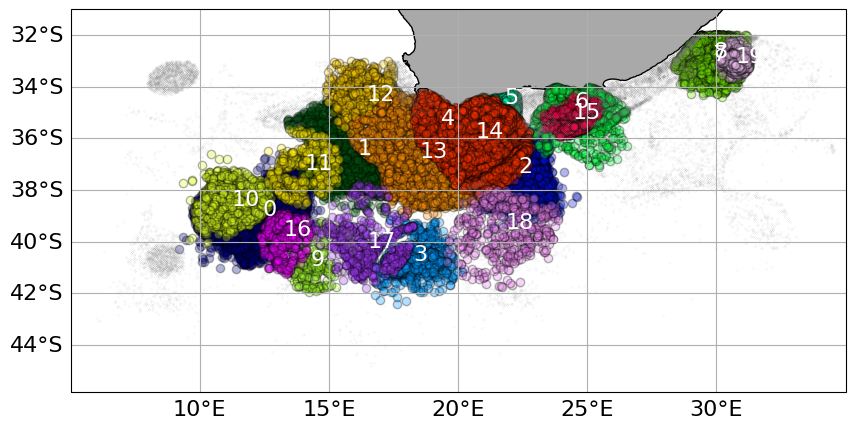

In [5]:
create_real_world_image(coordinates, default_labels, f'64_vocc_clustering_{DEPTH_STRIDE}', True)

## Depth estimation

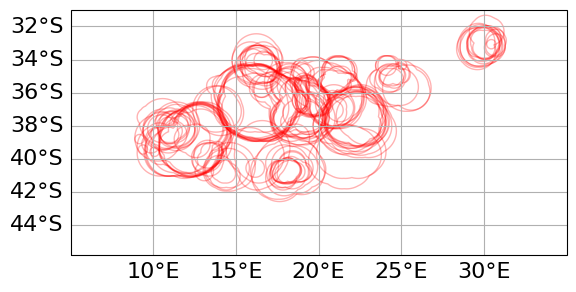

In [6]:
# Draw all outlines of each vortex and each depth into a single plot

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection=PlateCarree())

for vortex in vocc.vortices_:
    areas = []

    for d_i, d in enumerate(np.unique(vortex.pixels[:, 3])):
        depth_mask = vortex.pixels[:, 3] == d
        out_side_polygon = None
        for (circle_x, circle_y), radius in zip(vortex.get_circle_positions()[depth_mask], vortex.get_circle_radii()[depth_mask]): 
      
                
            circle_x = circle_x * vocc.cell_size + vocc.min_positions[0]
            circle_y = circle_y * vocc.cell_size + vocc.min_positions[1]
            radius = radius * vocc.cell_size
            # ax.add_patch(Circle((circle_x, circle_y), radius, fill=False, color='red'))

            abc = Point(circle_x, circle_y).buffer(radius)
            
            if out_side_polygon is None:
                out_side_polygon = abc
            else:
                out_side_polygon = out_side_polygon.union(abc)


        if out_side_polygon is not None:
            
            ax.add_geometries([out_side_polygon], crs=PlateCarree(), edgecolor='red', facecolor = 'none', alpha=.3)


gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.top_labels, gl.right_labels = False, False
gl.xlabel_style, gl.ylabel_style = {'fontsize': font_size}, {'fontsize': font_size}

lat_min = -45
lat_max = -31
lon_min = 5
lon_max = 35
ax.set_extent([lon_min, lon_max, lat_min, lat_max])


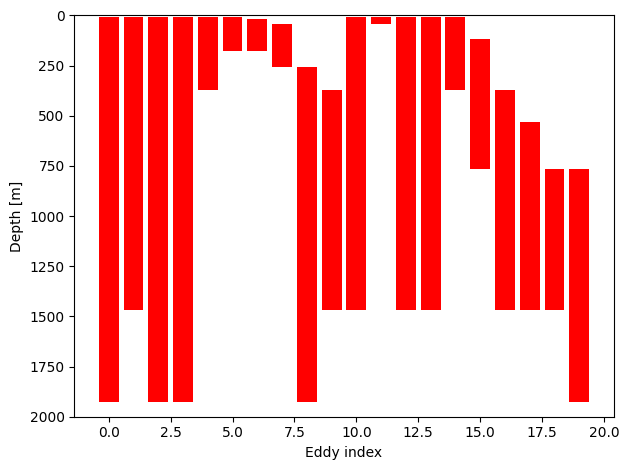

In [7]:
# Visualize the depth boundaries of the eddies as a bar plot.

fig = plt.figure()
ax = fig.add_subplot(1,1,1)


depth_boundaries = np.empty(shape = (len(vocc.vortices_), 2))
for v_i, vortex in enumerate(vocc.vortices_):
    depth_boundaries[v_i, 0] = depth_layers[::DEPTH_STRIDE][vortex.get_depth_layers().min().astype(int)] - .5 * ( depth_layers[::DEPTH_STRIDE][vortex.get_depth_layers().min().astype(int)] -  depth_layers[::DEPTH_STRIDE][vortex.get_depth_layers().min().astype(int) - 1])
    depth_boundaries[v_i, 1] = depth_layers[::DEPTH_STRIDE][vortex.get_depth_layers().max().astype(int)] + .5 * ( depth_layers[::DEPTH_STRIDE][vortex.get_depth_layers().max().astype(int) + 1] -  depth_layers[::DEPTH_STRIDE][vortex.get_depth_layers().max().astype(int)])

plt.bar(np.arange(len(vocc.vortices_)), depth_boundaries[:, 1] - depth_boundaries[:, 0], bottom = depth_boundaries[:, 0], color = 'red')

ax.set_ylim(0, 2000)
ax.invert_yaxis()

ax.set_ylabel('Depth [m]')
ax.set_xlabel('Eddy index')
fig.tight_layout()
plt.savefig('../fig/64_depth_boundaries_bar.png', dpi=400)


## Area decreses with depth

In [8]:
# Calculate the areas of the vertex for each of the depth levels they cover. And normalize this with the maximum of the areas along the depth.

normalized_areas_vortices = []
for vortex in vocc.vortices_:
    areas = []

    for d_i, d in enumerate(np.unique(vortex.pixels[:, 3])):
        depth_mask = vortex.pixels[:, 3] == d
        out_side_polygon = None
        for (circle_x, circle_y), radius in zip(vortex.get_circle_positions()[depth_mask], vortex.get_circle_radii()[depth_mask]): 
      
                
            circle_x = circle_x * vocc.cell_size + vocc.min_positions[0]
            circle_y = circle_y * vocc.cell_size + vocc.min_positions[1]
            radius = radius * vocc.cell_size
            # ax.add_patch(Circle((circle_x, circle_y), radius, fill=False, color='red'))

            abc = Point(circle_x, circle_y).buffer(radius)
            
            if out_side_polygon is None:
                out_side_polygon = abc
            else:
                out_side_polygon = out_side_polygon.union(abc)


        if out_side_polygon is not None:

            areas.append(out_side_polygon.area)
    areas = np.array(areas)

    normalized_areas_vortices.append(areas / np.max(areas))
        


In [9]:
# Calculate for each depth the std of the normalized area
max_depth_levels = max(len(nav) for nav in normalized_areas_vortices)
std_normalized_areas = np.zeros((max_depth_levels, 2))
for i in range(max_depth_levels):
    std_normalized_areas[i, 0] = np.mean([v[i] for v in normalized_areas_vortices if len(v) > i])
    std_normalized_areas[i, 1] = np.std([v[i] for v in normalized_areas_vortices if len(v) > i])
    

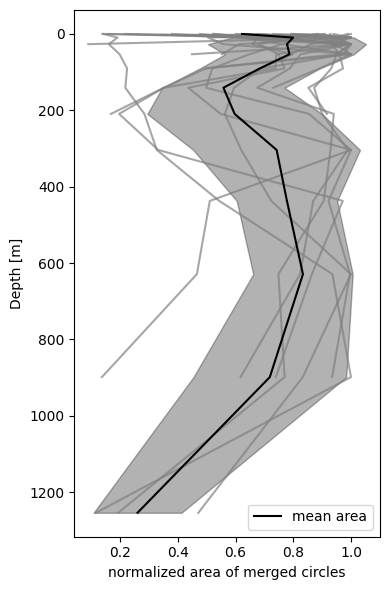

In [10]:
# Visualize the normalized areas of the vortices as single lines and the mean and std as a shaded area.

fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(1,1,1)

for vortices_depth in normalized_areas_vortices:
    # ax.plot(vortices_depth, np.arange(len(vortices_depth)))
    ax.plot(vortices_depth, depth_layers[::DEPTH_STRIDE][:len(vortices_depth)], color = 'grey', alpha = .7)

ax.set_xlabel('normalized area of merged circles')
ax.invert_yaxis()
ax.set_ylabel('Depth [m]')

# ax.plot(std_normalized_areas[:, 0], np.arange(std_normalized_areas.shape[0]), label='First depth layer', c = 'black')
ax.plot(std_normalized_areas[:, 0],depth_layers[::DEPTH_STRIDE][:std_normalized_areas.shape[0]], c = 'black', label='mean area')

# ax.fill_betweenx(np.arange(std_normalized_areas.shape[0]), std_normalized_areas[:, 0] - std_normalized_areas[:, 1], std_normalized_areas[:, 0] + std_normalized_areas[:, 1], alpha = .3, color = 'black')
ax.fill_betweenx(depth_layers[::DEPTH_STRIDE][:std_normalized_areas.shape[0]], std_normalized_areas[:, 0] - std_normalized_areas[:, 1], std_normalized_areas[:, 0] + std_normalized_areas[:, 1], alpha = .3, color = 'black')
ax.legend()

fig.tight_layout()
plt.savefig('../fig/64_area_depth.png', dpi = 400)

## Divergence of eddy centers

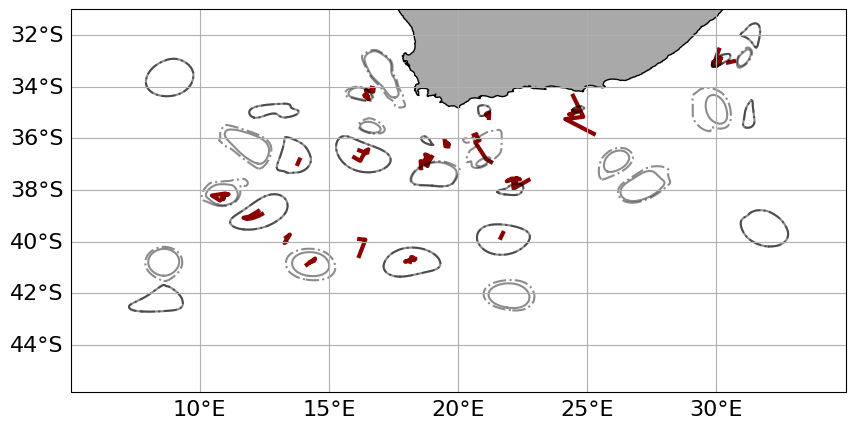

In [11]:
# Track the center of the circles in each depth layer and plot its path together with the vortices from py-eddy-tracker.

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1, projection=PlateCarree())

for vortex in vocc.vortices_:
    mean_path = np.empty(shape = (np.unique(vortex.pixels[:, 3]).shape[0], 2), dtype = np.float32)
    for d_i, d in enumerate(np.unique(vortex.pixels[:, 3])):
        depth_mask = vortex.pixels[:, 3] == d

        mean_position = np.mean(vortex.pixels[depth_mask, :2], axis = 0) * vocc.cell_size + vocc.min_positions

        mean_path[d_i] = mean_position

    ax.plot(mean_path[:,0], mean_path[:,1], transform=PlateCarree(), linewidth = 3, color = 'darkred')

ax.add_feature(COASTLINE)
ax.add_feature(LAND, facecolor = 'darkgrey')

def extract_lagrangian_eddies(eddy_dataset, particles_x, particles_y, particle_threshold):
    counts, _ = np.histogram(eddy_dataset.contains(particles_x, particles_y), bins = np.arange( len(eddy_dataset)+1))
    mask_indices = np.argwhere(counts >= particle_threshold).squeeze()

    mask = np.zeros(len(eddy_dataset.obs), dtype=bool)
    mask[mask_indices] = True

    return eddy_dataset.extract_with_mask(mask)


extract_lagrangian_eddies(c, X, Y, MIN_PARTICLES).display(ax, transform = PlateCarree(), alpha = .45, color = 'black')
extract_lagrangian_eddies(a, X, Y, MIN_PARTICLES).display(ax, transform = PlateCarree(), alpha = .45, color = 'black')

gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.top_labels, gl.right_labels = False, False
gl.xlabel_style, gl.ylabel_style = {'fontsize': font_size}, {'fontsize': font_size}

lat_min = -45
lat_max = -31
lon_min = 5
lon_max = 35
ax.set_extent([lon_min, lon_max, lat_min, lat_max])


plt.savefig('../fig/64_vortex_path.png', dpi = 400)

### Depth histogram

/tmp/ipykernel_3608546/1267864449.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(-d)}' for d in ax.get_yticks()])


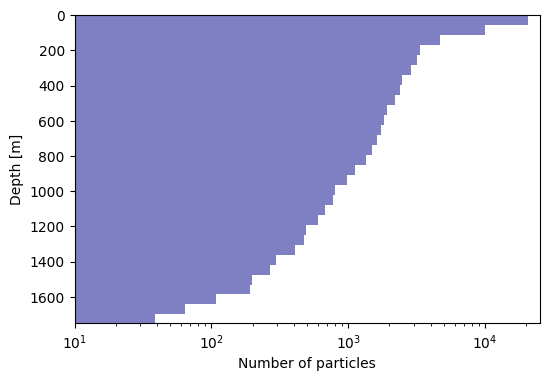

In [12]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.hist(D, bins = 40, color = 'darkblue', orientation='horizontal', histtype='barstacked', alpha = .5, label='All particles')
ax.set_xscale('log')
ax.set_ylim(-1750,0)
ax.set_xlabel('Number of particles')
ax.set_ylabel('Depth [m]')

ax.set_yticklabels([f'{int(-d)}' for d in ax.get_yticks()])
ax.set_xlim(10, 25000)

plt.savefig('../fig/64_depth_histogram.png', dpi = 400)